Upload your CSV file (Global Tech Gadget Consumption Data (2015-2025).csv)


Saving archive (9).zip to archive (9) (2).zip
Loaded file: archive (9) (2).zip

Preview of dataset:


,Country,Year,Smartphone Sales (Millions),Laptop Shipments (Millions),Gaming Console Adoption (%),Smartwatch Penetration (%),Average Consumer Spending on Gadgets ($),E-Waste Generated (Metric Tons),5G Penetration Rate (%)
0,USA,2015,111.37,123.63,12.05,14.49,311.21,939.89,54.64
1,USA,2016,224.65,65.27,12.92,9.88,250.46,1361.42,53.61
2,USA,2017,102.12,26.75,19.63,17.35,2404.22,872.52,29.94
3,USA,2018,148.10,129.28,26.44,12.45,1883.37,1241.41,75.88
4,USA,2019,83.93,97.81,20.84,6.18,777.42,1939.39,76.26


Could not auto-detect India shipments column. Please enter the column name exactly as in your CSV.
Column name for India smartphone shipments: Smartphone Sales (Millions)
Using India shipments column: Smartphone Sales (Millions)


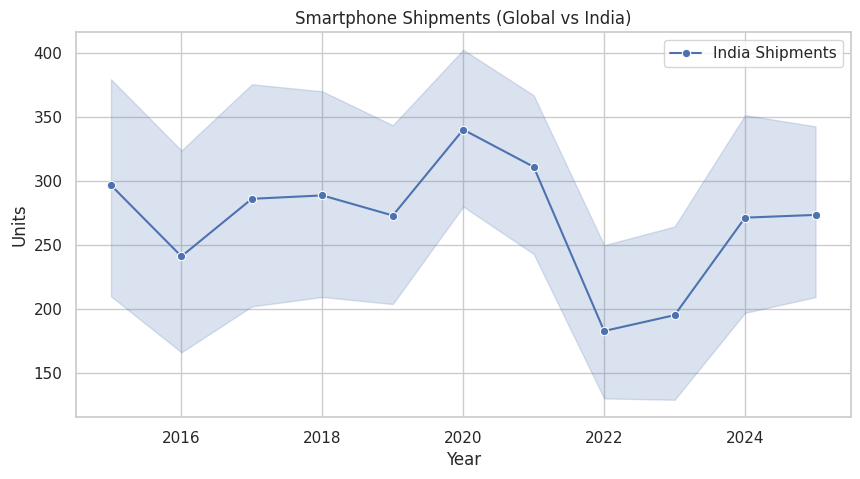

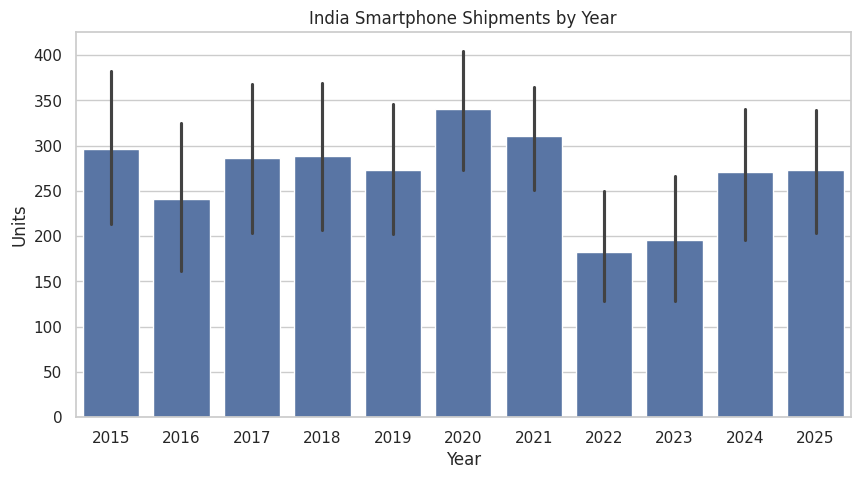


Baseline year: 2025, India shipments baseline: 367


Output()


Done. Use the sliders above to experiment with base price, elasticity, and objective.


In [ ]:

from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import ipywidgets as widgets

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)


print("Upload your CSV file (Global Tech Gadget Consumption Data (2015-2025).csv)")
uploaded = files.upload()


fn = list(uploaded.keys())[0]
print(f"Loaded file: {fn}")
df = pd.read_csv(fn)


print("\nPreview of dataset:")
display(df.head())


possible_cols = df.columns.tolist()
india_shipment_col = None
for c in possible_cols:
    if 'india' in c.lower() and ('ship' in c.lower() or 'unit' in c.lower() or 'sold' in c.lower()):
        india_shipment_col = c
        break


if india_shipment_col is None:
    for guess in ['India_Smartphone_Shipments', 'Smartphone_Shipments_India', 'India_Shipments']:
        if guess in df.columns:
            india_shipment_col = guess
            break

if india_shipment_col is None:
    print("Could not auto-detect India shipments column. Please enter the column name exactly as in your CSV.")
    india_shipment_col = input("Column name for India smartphone shipments: ").strip()

print(f"Using India shipments column: {india_shipment_col}")


plt.figure()

if 'Global_Smartphone_Shipments' in df.columns:
    sns.lineplot(data=df, x='Year', y='Global_Smartphone_Shipments', marker='o', label='Global Shipments')

sns.lineplot(data=df, x='Year', y=india_shipment_col, marker='o', label='India Shipments')
plt.title("Smartphone Shipments (Global vs India)")
plt.ylabel("Units")
plt.legend()
plt.show()


plt.figure()
sns.barplot(data=df, x='Year', y=india_shipment_col)
plt.title("India Smartphone Shipments by Year")
plt.ylabel("Units")
plt.show()


latest_row = df.loc[df['Year'].idxmax()]
baseline_india_shipments = float(latest_row[india_shipment_col])
latest_year = int(latest_row['Year'])
print(f"\nBaseline year: {latest_year}, India shipments baseline: {int(baseline_india_shipments):,}")


def shipments_model(p, baseline=baseline_india_shipments, elasticity=1.0):
    """
    Simple linear elasticity model: shipments(p) = baseline * (1 + elasticity * p)
    p is price-cut fraction (0..0.5)
    """
    return baseline * (1.0 + elasticity * p)

def revenue_model(p, base_price, baseline=baseline_india_shipments, elasticity=1.0):
    price_after = base_price * (1.0 - p)
    units = shipments_model(p, baseline, elasticity)
    return price_after * units

def profit_model(p, base_price, cost_per_unit, baseline=baseline_india_shipments, elasticity=1.0):
    price_after = base_price * (1.0 - p)
    units = shipments_model(p, baseline, elasticity)
    return (price_after - cost_per_unit) * units

def golden_section_maximize(f, a=0.0, b=0.5, tol=1e-6, maxiter=200):
    gr = (np.sqrt(5) + 1.0) / 2.0
    c = b - (b - a) / gr
    d = a + (b - a) / gr
    fc = f(c)
    fd = f(d)
    it = 0
    while abs(b - a) > tol and it < maxiter:
        if fc > fd:
            b = d
            d = c
            fd = fc
            c = b - (b - a) / gr
            fc = f(c)
        else:
            a = c
            c = d
            fc = fd
            d = a + (b - a) / gr
            fd = f(d)
        it += 1
    p_opt = (b + a) / 2.0
    return p_opt, f(p_opt), it


def run_and_plot(base_price=1400.0, elasticity=1.0, cost_per_unit=900.0, objective='Maximize Shipments'):

    if objective == 'Maximize Shipments':
        f = lambda p: shipments_model(p, baseline_india_shipments, elasticity)
    elif objective == 'Maximize Revenue':
        f = lambda p: revenue_model(p, base_price, baseline_india_shipments, elasticity)
    else:
        f = lambda p: profit_model(p, base_price, cost_per_unit, baseline_india_shipments, elasticity)

    p_opt, val_opt, iters = golden_section_maximize(f, a=0.0, b=0.5, tol=1e-6)

    ship_opt = shipments_model(p_opt, baseline_india_shipments, elasticity)
    price_after = base_price * (1.0 - p_opt)
    revenue_opt = revenue_model(p_opt, base_price, baseline_india_shipments, elasticity)
    profit_opt = profit_model(p_opt, base_price, cost_per_unit, baseline_india_shipments, elasticity)


    print("=== Optimization Results ===")
    print(f"Objective          : {objective}")
    print(f"Elasticity         : {elasticity}")
    print(f"Baseline year      : {latest_year}")
    print(f"Baseline shipments : {int(baseline_india_shipments):,}")
    print(f"Optimal p (cut)    : {p_opt:.6f} ({p_opt*100:.3f}%)")
    print(f"Shipments at opt   : {int(ship_opt):,}")
    print(f"Price after cut    : {price_after:.2f}")
    print(f"Revenue at opt     : {revenue_opt:,.2f}")
    print(f"Profit at opt      : {profit_opt:,.2f}")
    print(f"Iterations         : {iters}\n")


    ps = np.linspace(0.0, 0.5, 1001)
    shipments_vec = [shipments_model(p, baseline_india_shipments, elasticity) for p in ps]
    revenue_vec = [revenue_model(p, base_price, baseline_india_shipments, elasticity) for p in ps]
    profit_vec = [profit_model(p, base_price, cost_per_unit, baseline_india_shipments, elasticity) for p in ps]

    fig, ax = plt.subplots(1, 3, figsize=(18,4))
    ax[0].plot(ps, shipments_vec)
    ax[0].scatter([p_opt], [ship_opt], color='red')
    ax[0].set_title("Shipments vs Price-Cut p")
    ax[0].set_xlabel("p (price cut fraction)")
    ax[0].set_ylabel("Shipments (units)")

    ax[1].plot(ps, revenue_vec)
    ax[1].scatter([p_opt], [revenue_opt], color='red')
    ax[1].set_title("Revenue vs p")
    ax[1].set_xlabel("p")
    ax[1].set_ylabel("Revenue")

    ax[2].plot(ps, profit_vec)
    ax[2].scatter([p_opt], [profit_opt], color='red')
    ax[2].set_title("Profit vs p")
    ax[2].set_xlabel("p")
    ax[2].set_ylabel("Profit")

    plt.tight_layout()
    plt.show()

base_price_w = widgets.FloatSlider(value=1400.0, min=200.0, max=3000.0, step=10.0, description='Base Price')
elasticity_w = widgets.FloatSlider(value=1.0, min=0.0, max=5.0, step=0.05, description='Elasticity')
cost_w = widgets.FloatSlider(value=900.0, min=0.0, max=2000.0, step=10.0, description='Cost/unit')
objective_w = widgets.Dropdown(options=['Maximize Shipments', 'Maximize Revenue', 'Maximize Profit'],
                               value='Maximize Shipments', description='Objective')

ui = widgets.VBox([base_price_w, elasticity_w, cost_w, objective_w])
out = widgets.interactive_output(run_and_plot, {'base_price': base_price_w,
                                               'elasticity': elasticity_w,
                                               'cost_per_unit': cost_w,
                                               'objective': objective_w})
display(ui, out)


if 'Year' in df.columns and df['Year'].max() < 2025:
    extra = pd.DataFrame([
        {"Year": 2024, india_shipment_col: baseline_india_shipments * 1.02},
        {"Year": 2025, india_shipment_col: baseline_india_shipments * 1.04},
    ])


print("\nDone. Use the sliders above to experiment with base price, elasticity, and objective.")

In [ ]:
!pip install pandas matplotlib seaborn scipy

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import minimize_scalar


In [ ]:
df = pd.read_csv("/content/archive (9).zip")
print(df.head())

  Country  Year  Smartphone Sales (Millions)  Laptop Shipments (Millions)  \
0     USA  2015                       111.37                       123.63   
1     USA  2016                       224.65                        65.27   
2     USA  2017                       102.12                        26.75   
3     USA  2018                       148.10                       129.28   
4     USA  2019                        83.93                        97.81   

   Gaming Console Adoption (%)  Smartwatch Penetration (%)  \
0                        12.05                       14.49   
1                        12.92                        9.88   
2                        19.63                       17.35   
3                        26.44                       12.45   
4                        20.84                        6.18   

   Average Consumer Spending on Gadgets ($)  E-Waste Generated (Metric Tons)  \
0                                    311.21                           939.89   
1   

In [ ]:
def shipments(year):
    """Return smartphone shipments for a given year (interpolated)."""
    return np.interp(year, df['Year'], df['Smartphone Sales (Millions)'])

# We want to maximize, but minimize_scalar minimizes, so use -shipments
res = minimize_scalar(lambda x: -shipments(x),
                      bounds=(df['Year'].min(), df['Year'].max()),
                      method='bounded')

In [ ]:
best_year = res.x
best_value = shipments(best_year)
print(f"Best year for smartphone shipments in India: {best_year:.0f} ({best_value:.2f} million units)")

Best year for smartphone shipments in India: 2021 (328.38 million units)


In [ ]:

sns.set(style="whitegrid", palette="muted")

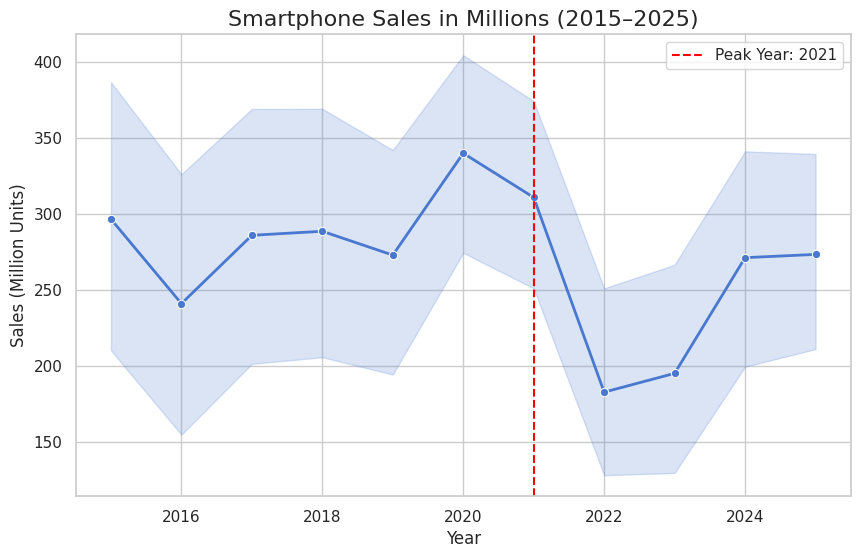

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(x="Year", y="Smartphone Sales (Millions)", data=df, marker="o", linewidth=2)
plt.axvline(best_year, color='red', linestyle='--', label=f'Peak Year: {best_year:.0f}')
plt.title("Smartphone Sales in Millions (2015–2025)", fontsize=16)
plt.ylabel("Sales (Million Units)")
plt.legend()
plt.show()

In [ ]:
if "Android_Market_Share" in df.columns and "iOS_Market_Share" in df.columns:
    plt.figure(figsize=(10,6))
    plt.plot(df["Year"], df["Android_Market_Share"], marker="o", label="Android")
    plt.plot(df["Year"], df["iOS_Market_Share"], marker="o", label="iOS")
    plt.title("Smartphone Market Share in India", fontsize=16)
    plt.ylabel("Market Share (%)")
    plt.legend()
    plt.show()

In [ ]:
if "Total_Gadget_Consumption" in df.columns:
    plt.figure(figsize=(10,6))
    sns.barplot(x="Year", y="Total_Gadget_Consumption", data=df)
    plt.title("Total Gadget Consumption (2015–2025)", fontsize=16)
    plt.ylabel("Consumption (Million Units)")
    plt.xticks(rotation=45)
    plt.show()